# NYC MTA Bus Lane Enforcement: An In-Depth Analysis

## Project Overview
This notebook presents a focused, comparative analysis of the NYC MTA's Bus Automated Camera Enforcement (ACE) program within Manhattan. By isolating and contrasting the three bus routes with the highest number of recorded obstructions against the three with the lowest, this project investigates the root causes of violation disparities and their tangible impact on service performance. The analysis delves into the specific profiles of these two distinct route groups, comparing their violation types, temporal patterns, and historical bus speeds to provide targeted insights into why certain corridors are more problematic and to assess the localized effectiveness of camera enforcement on improving bus flow.

## Analysis Goals:
1.  **Manhattan Route Analysis**: Comparing the violation profiles (types, times) of the top 3 vs. bottom 3 routes.
2.  **Bus Speed Analysis**: Analyzing and comparing the historical bus speeds for those same six routes.

## Dataset Information
The dataset contains MTA Bus Automated Camera Enforcement Violations with the following key features:
* 

# Section 1: Data Loading and Initial Exploration
We begin by loading the required libraries and examining the structure of our violation dataset to understand what data is available for analysis.

In [3]:
# Import required libraries for data analysis and visualization
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully")

Libraries imported successfully


In [ ]:
# Define File Path to Bus Violation
path_to_data = '../data/raw/'
all_csv_files = glob.glob(os.path.join(path_to_data, "mta_bus_ace_violation_*.csv"))

if not all_csv_files:
    print("Error: No CSV files found! Check the path and file naming.")
else:
    print(f"Found {len(all_csv_files)} CSV files to combine.")

# Load and Combine Files
# Create an empty list to hold each individual DataFrame
df_list = []

# Read each CSV file into a DataFrame
for file in all_csv_files:
    df_temp = pd.read_csv(file) 
    df_list.append(df_temp)
    print(f"Loaded {os.path.basename(file)} with {len(df_temp)} rows.")

# Concatenate all the DataFrames in the list into one master DataFrame
df_combined_raw = pd.concat(df_list, ignore_index=True)

# Save the Combined Raw Data
output_path = '../data/processed/00_combined_raw_data.csv'
df_combined_raw.to_csv(output_path, index=False)

print("\n-------------------------------------------")
print(f"All files successfully combined!")
print(f"Total rows in combined dataset: {len(df_combined_raw)}")
print(f"Combined raw data saved to: {output_path}")

Found 12 CSV files to combine.
Loaded mta_bus_ace_violation_q54.csv with 88424 rows.
Loaded mta_bus_ace_violation_q69.csv with 5794 rows.
Loaded mta_bus_ace_violation_m101.csv with 312466 rows.
Loaded mta_bus_ace_violation_q44+.csv with 164806 rows.
Loaded mta_bus_ace_violation_q5.csv with 31230 rows.
Loaded mta_bus_ace_violation_m23+.csv with 16406 rows.
Loaded mta_bus_ace_violation_m42.csv with 5729 rows.
Loaded mta_bus_ace_violation_q53+.csv with 36728 rows.
Loaded mta_bus_ace_violation_m60+.csv with 100427 rows.
Loaded mta_bus_ace_violation_q58.csv with 97785 rows.
Loaded mta_bus_ace_violation_m15.csv with 502765 rows.
Loaded mta_bus_ace_violation_m4.csv with 13031 rows.

-------------------------------------------
All files successfully combined!
Total rows in combined dataset: 1375591
Combined raw data saved to: ../data/processed/00_combined_raw_data.csv


## Section 2: Data Preprocessing and Cleaning
Now we clean and preprocess the data to prepare it for analysis. This includes handling missing values, converting data types, and extracting temporal features that will be crucial for our time-based analysis.

In [14]:

# Load the combined raw data
try:
    df_raw = pd.read_csv('../data/processed/00_combined_raw_data.csv', low_memory=False)
    print("Combined raw data loaded successfully.")
except FileNotFoundError:
    print("Error: Combined raw data file not found. Please run '01_data_fetch.ipynb' first.")
    exit()

# Convert 'First Occurrence' to a proper datetime format
df_raw['First Occurrence'] = pd.to_datetime(df_raw['First Occurrence'], errors='coerce')

# Drop rows with critical missing values that make analysis impossible
df_raw.dropna(subset=['First Occurrence', 'Bus Route ID', 'Violation Status'], inplace=True)

# Clean whitespace from the status column, which can cause grouping issues
df_raw['Violation Status'] = df_raw['Violation Status'].str.strip()

# Define a function to get the borough from a route ID
def get_borough(route_id):
    if not isinstance(route_id, str): return 'Unknown'
    if route_id.startswith('M'): return 'Manhattan'
    if route_id.startswith('BX'): return 'Bronx'
    if route_id.startswith('B'): return 'Brooklyn'
    if route_id.startswith('Q'): return 'Queens'
    if route_id.startswith('S'): return 'Staten Island'
    return 'Unknown'
df_raw['Borough'] = df_raw['Bus Route ID'].apply(get_borough)

# Define a function to create a simple binary category: "Illegal" vs "Exempt"
def get_obstruction_type(status):
    if 'EXEMPT' in status:
        return 'Exempt Obstruction'
    return 'Illegal Violation'
df_raw['Obstruction Type'] = df_raw['Violation Status'].apply(get_obstruction_type)
print("New columns ('Borough', 'Obstruction Type') created.")

# Dataset A: Contains ONLY records considered to be illegal violations.
df_violations = df_raw[df_raw['Obstruction Type'] == 'Illegal Violation'].copy()

# Dataset B: Contains ALL records, which will be used for the detailed breakdown.
df_obstructions = df_raw.copy()

# Save the two final datasets, ready for EDA.
df_violations.to_csv('../data/processed/mta_violations_cleaned.csv', index=False)
print(f"  - Saved {len(df_violations)} rows of illegal violations to 'mta_violations_cleaned.csv'")

df_obstructions.to_csv('../data/processed/mta_obstructions_categorized.csv', index=False)
print(f"  - Saved {len(df_obstructions)} rows of all obstructions to 'mta_obstructions_categorized.csv'")

print("\nData cleaning complete!")

Combined raw data loaded successfully.


/var/folders/p_/kfck2c0s3054xc_d99qkkpxh0000gn/T/ipykernel_10928/1820515185.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw['First Occurrence'] = pd.to_datetime(df_raw['First Occurrence'], errors='coerce')


New columns ('Borough', 'Obstruction Type') created.
  - Saved 988849 rows of illegal violations to 'mta_violations_cleaned.csv'
  - Saved 1375591 rows of all obstructions to 'mta_obstructions_categorized.csv'

Data cleaning complete!


In [16]:
# Clean all routes in the dataset for bus speed
df_speeds['month'] = pd.to_datetime(df_speeds['month'])
df_speeds['Day Category'] = df_speeds['day_type'].map({1: 'Weekday', 2: 'Weekend'})

## Section 3: Manhattan Exploratory Data Analysis

Clean datasets loaded.
Data filtered for Manhattan analysis. Using 655029 violation rows.
--- Total Violations for Target Manhattan Routes ---
  Bus Route ID  Total Violations
0         M15+            334649
1         M101            221647
2         M60+             76128
3           M4              9910
4         M23+              9550
5          M42              3145


/var/folders/p_/kfck2c0s3054xc_d99qkkpxh0000gn/T/ipykernel_10928/2613672217.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


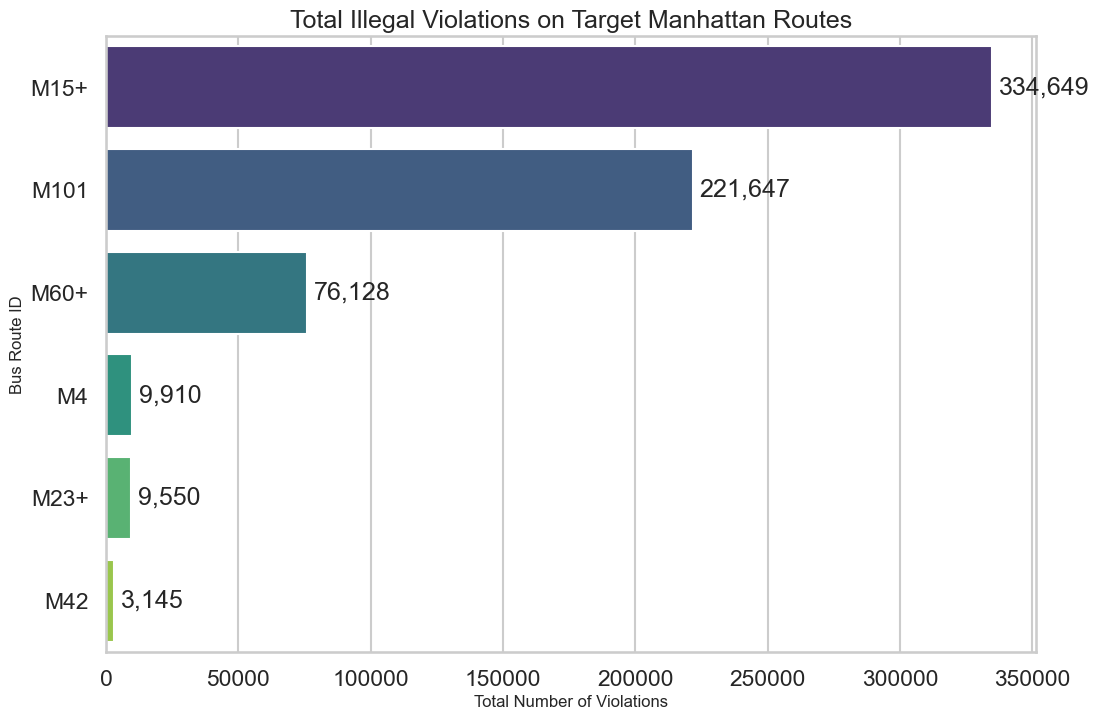

/var/folders/p_/kfck2c0s3054xc_d99qkkpxh0000gn/T/ipykernel_10928/2613672217.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  level_trends = df_violations.groupby([pd.Grouper(key='First Occurrence', freq='M'), 'Violation Level']).size().unstack(level='Violation Level', fill_value=0)


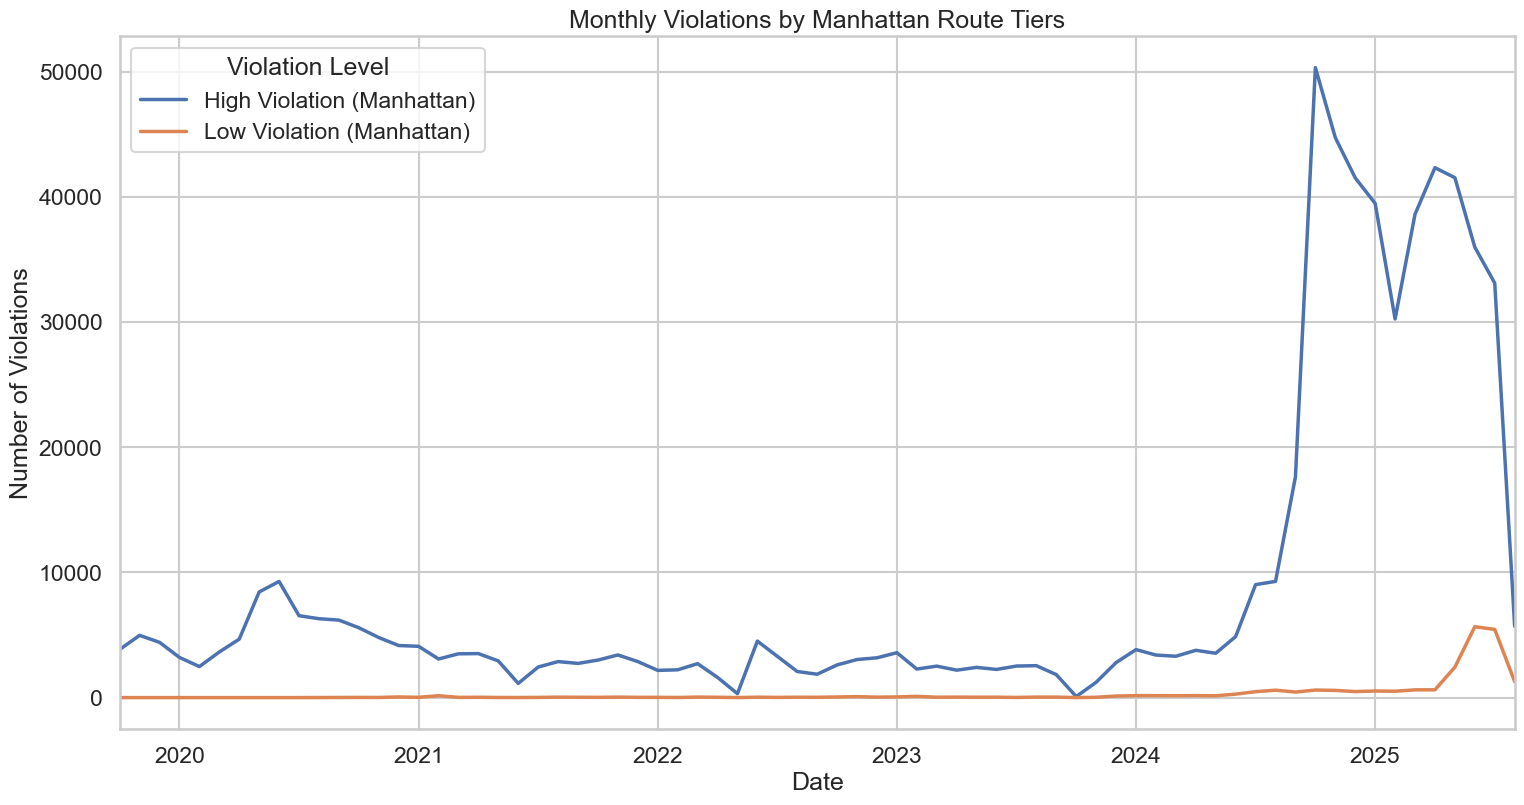


--- Part II: Generating plots for All Obstructions in Manhattan ---


/var/folders/p_/kfck2c0s3054xc_d99qkkpxh0000gn/T/ipykernel_10928/2613672217.py:75: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  total_obstructions = df_obstructions.groupby([pd.Grouper(key='First Occurrence', freq='M'), 'Obstruction Type']).size().unstack(level='Obstruction Type', fill_value=0)


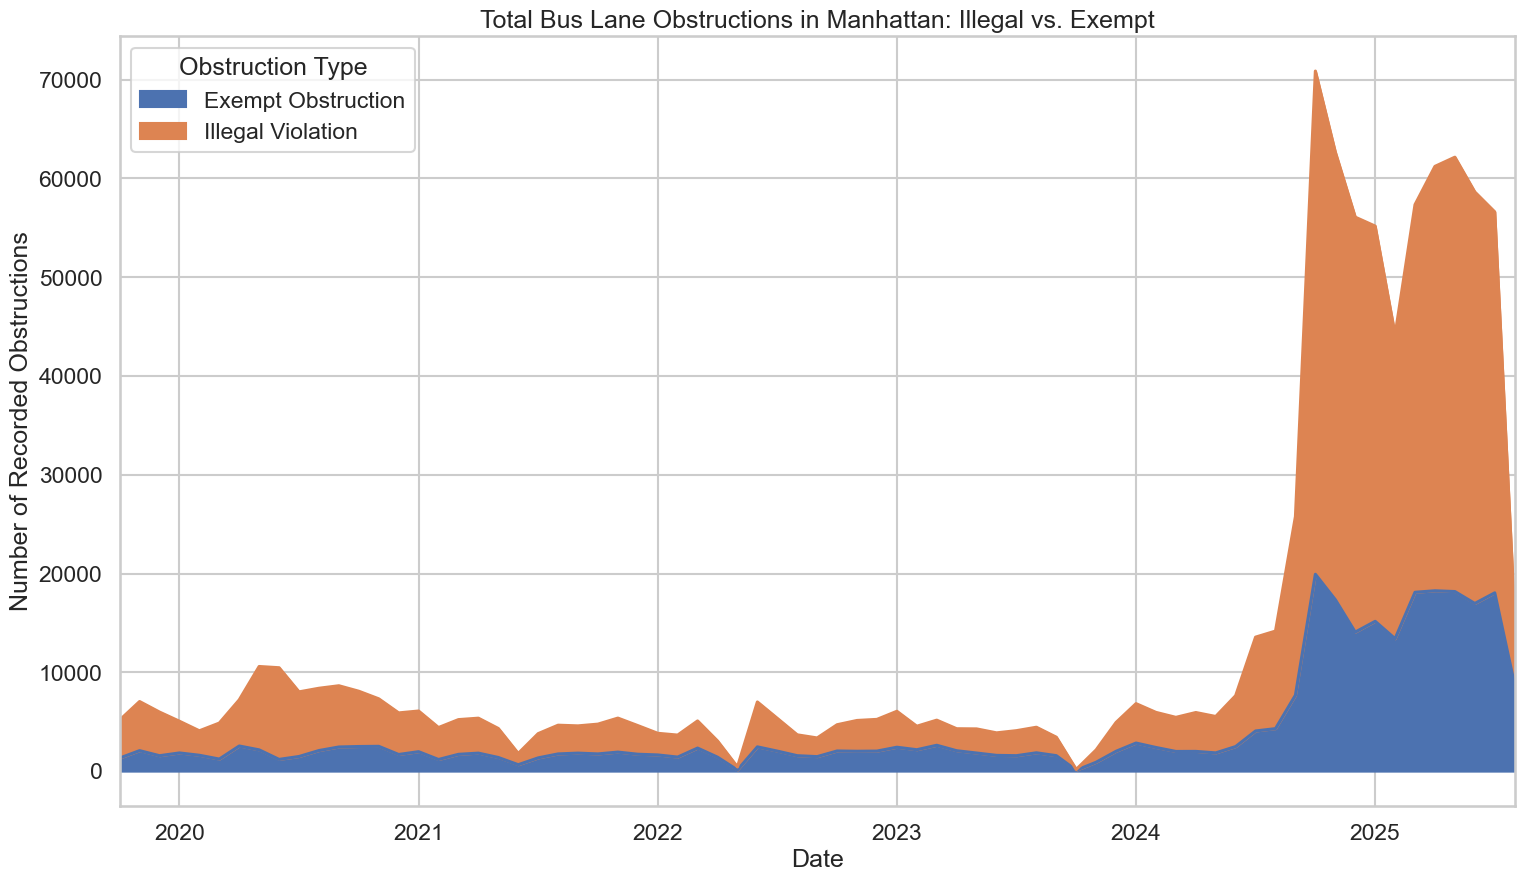

/var/folders/p_/kfck2c0s3054xc_d99qkkpxh0000gn/T/ipykernel_10928/2613672217.py:82: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  status_trends = df_obstructions.groupby([pd.Grouper(key='First Occurrence', freq='M'), 'Violation Status']).size().unstack(level='Violation Status', fill_value=0)


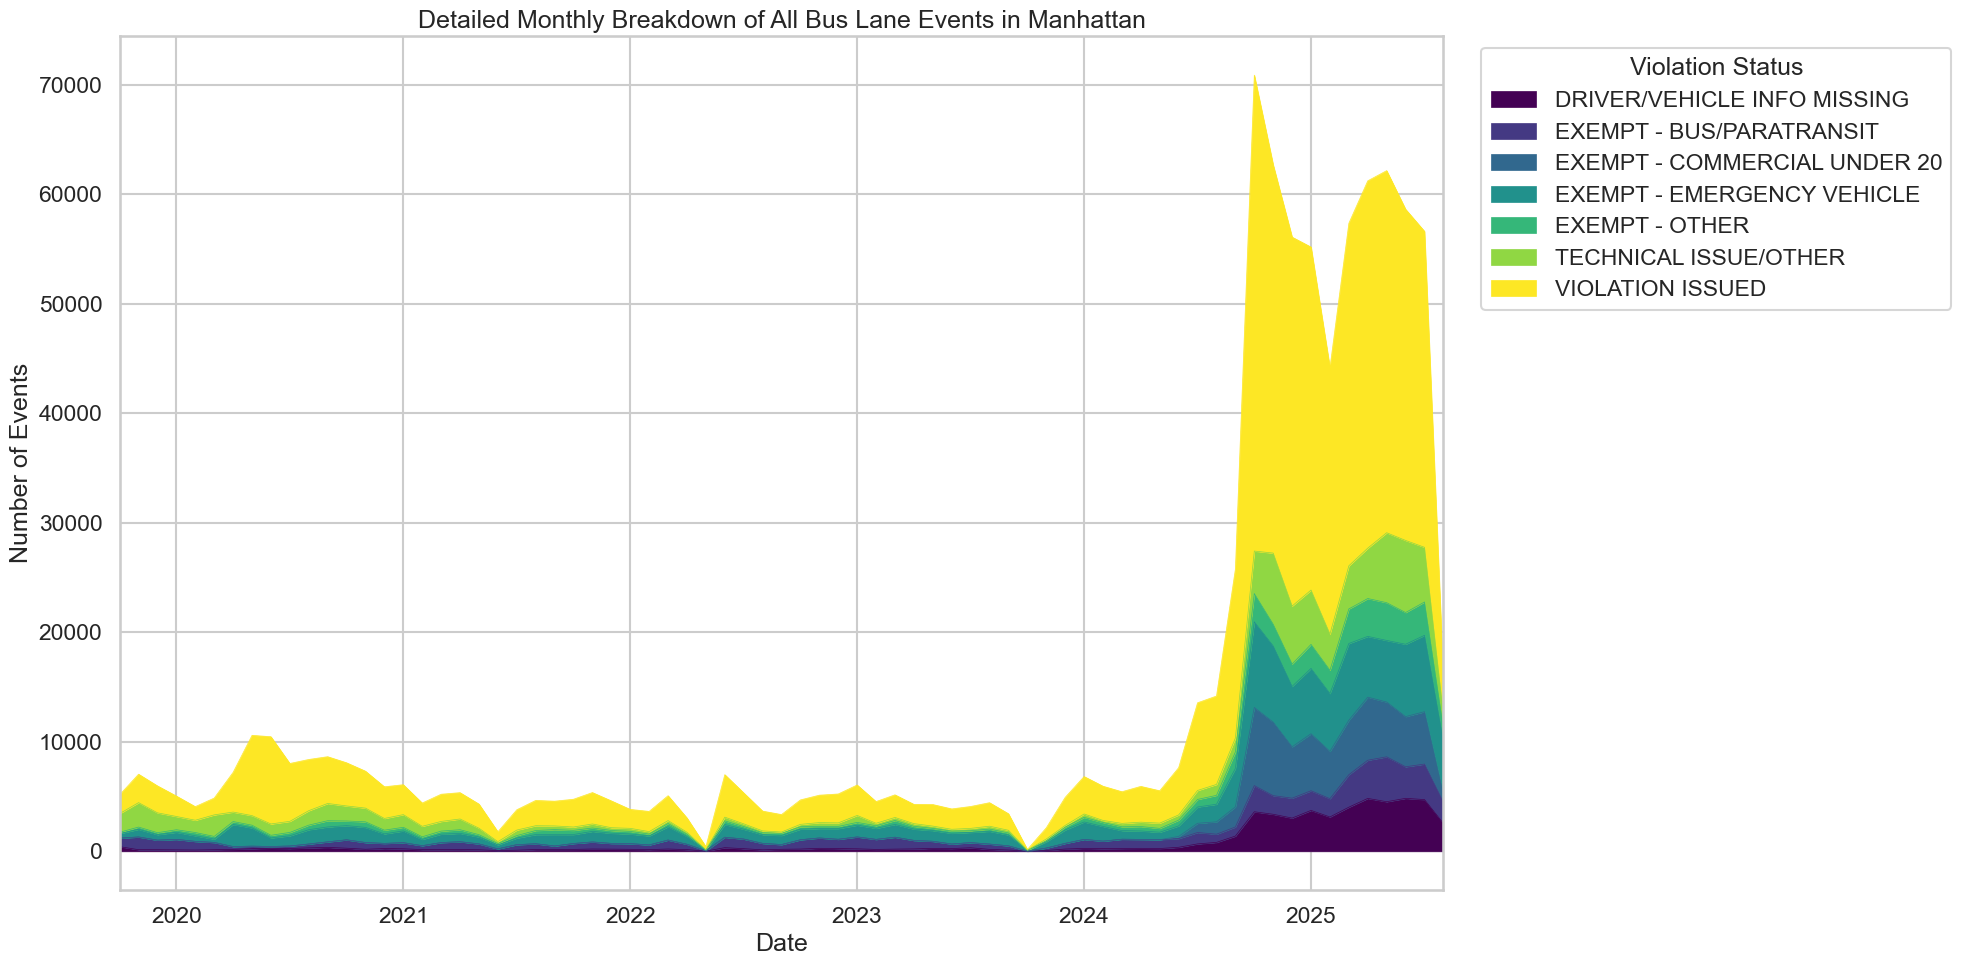


Manhattan Exploratory Data Analysis complete!


In [15]:
# Load clean data and set plotting style
sns.set_theme(style="whitegrid", context="talk")
df_violations_all = pd.read_csv('../data/processed/mta_violations_cleaned.csv', parse_dates=['First Occurrence'])
df_obstructions_all = pd.read_csv('../data/processed/mta_obstructions_categorized.csv', parse_dates=['First Occurrence'])
print("Clean datasets loaded.")

# Filter both DataFrames to focus only on Manhattan
df_violations = df_violations_all[df_violations_all['Borough'] == 'Manhattan'].copy()
df_obstructions = df_obstructions_all[df_obstructions_all['Borough'] == 'Manhattan'].copy()
print(f"Data filtered for Manhattan analysis. Using {len(df_violations)} violation rows.")

# Plot A: Monthly Violations for the 6 Manhattan Routes
manhattan_routes = df_violations['Bus Route ID'].value_counts()
manhattan_top_3 = manhattan_routes.nlargest(3).index.tolist()
manhattan_bottom_3 = manhattan_routes.nsmallest(3).index.tolist()
target_manhattan_routes = manhattan_top_3 + manhattan_bottom_3

# Calculate the total violations for just these 6 routes
target_counts = df_violations[df_violations['Bus Route ID'].isin(target_manhattan_routes)]['Bus Route ID'].value_counts().reset_index()
target_counts.columns = ['Bus Route ID', 'Total Violations']

print("--- Total Violations for Target Manhattan Routes ---")
print(target_counts)


# Create the Bar Chart
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=target_counts,
    x='Total Violations',
    y='Bus Route ID',
    palette='viridis',
    order=target_counts.sort_values('Total Violations', ascending=False)['Bus Route ID']
)

ax.set_title('Total Illegal Violations on Target Manhattan Routes', fontsize=18)
ax.set_xlabel('Total Number of Violations', fontsize=12)
ax.set_ylabel('Bus Route ID', fontsize=12)

# Add the exact number labels to the end of each bar
for p in ax.patches:
    width = p.get_width()
    # Use annotate() for placing text with an offset
    ax.annotate(
        f'{int(width):,}',                              # The text to display
        (width, p.get_y() + p.get_height() / 2),        # The point to annotate (end of bar)
        ha='left',                                      # Horizontal alignment
        va='center',                                    # Vertical alignment
        xytext=(5, 0),                                  # The offset in points
        textcoords='offset points'                      # The coordinate system for the offset
    )
plt.show()

# Plot B: Monthly Violations by Manhattan Route Category
# Define High/Medium/Low categories based on Manhattan's data distribution
route_counts = df_violations['Bus Route ID'].value_counts()
high_routes = route_counts[route_counts > 50000].index.tolist() # Adjusted threshold
medium_routes = route_counts[(route_counts > 10000) & (route_counts <= 50000)].index.tolist() # Adjusted threshold
def get_level(route):
    if route in high_routes: return 'High Violation (Manhattan)'
    if route in medium_routes: return 'Medium Violation (Manhattan)'
    return 'Low Violation (Manhattan)'

df_violations['Violation Level'] = df_violations['Bus Route ID'].apply(get_level)
level_trends = df_violations.groupby([pd.Grouper(key='First Occurrence', freq='M'), 'Violation Level']).size().unstack(level='Violation Level', fill_value=0)
fig, ax = plt.subplots(figsize=(18, 9))
level_trends.plot(ax=ax, title='Monthly Violations by Manhattan Route Tiers', lw=2.5)
ax.set(ylabel='Number of Violations', xlabel='Date')
plt.show()


print("\n--- Part II: Generating plots for All Obstructions in Manhattan ---")

# Plot C: Broad Categories (Illegal vs. Exempt) in Manhattan
total_obstructions = df_obstructions.groupby([pd.Grouper(key='First Occurrence', freq='M'), 'Obstruction Type']).size().unstack(level='Obstruction Type', fill_value=0)
fig, ax = plt.subplots(figsize=(18, 10))
total_obstructions.plot.area(ax=ax, stacked=True, title='Total Bus Lane Obstructions in Manhattan: Illegal vs. Exempt')
ax.set(ylabel='Number of Recorded Obstructions', xlabel='Date')
plt.show()

# Plot D: Granular Breakdown of All Statuses in Manhattan
status_trends = df_obstructions.groupby([pd.Grouper(key='First Occurrence', freq='M'), 'Violation Status']).size().unstack(level='Violation Status', fill_value=0)
fig, ax = plt.subplots(figsize=(20, 10))
status_trends.plot.area(ax=ax, stacked=True, linewidth=0.5, cmap='viridis')
ax.set(title='Detailed Monthly Breakdown of All Bus Lane Events in Manhattan', ylabel='Number of Events', xlabel='Date')
ax.legend(title='Violation Status', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nManhattan Exploratory Data Analysis complete!")

## Section 4: Manhattan Routes Analysis


Data filtered for Manhattan. Total rows: 950824

--- Identified Target Manhattan Routes ---
High Obstruction Routes: ['M15+', 'M101', 'M60+']
Low Obstruction Routes:  ['M42', 'M4', 'M23+']

Target DataFrame for Manhattan analysis created.

--- Applying Consistent Violation Status Order ---
['VIOLATION ISSUED', 'EXEMPT - EMERGENCY VEHICLE', 'TECHNICAL ISSUE/OTHER', 'EXEMPT - BUS/PARATRANSIT', 'EXEMPT - COMMERCIAL UNDER 20', 'DRIVER/VEHICLE INFO MISSING', 'EXEMPT - OTHER']

Split data into 3 high-obstruction and 3 low-obstruction routes.


/var/folders/p_/kfck2c0s3054xc_d99qkkpxh0000gn/T/ipykernel_10928/2690365577.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g_manhattan_high_pct = sns.catplot(


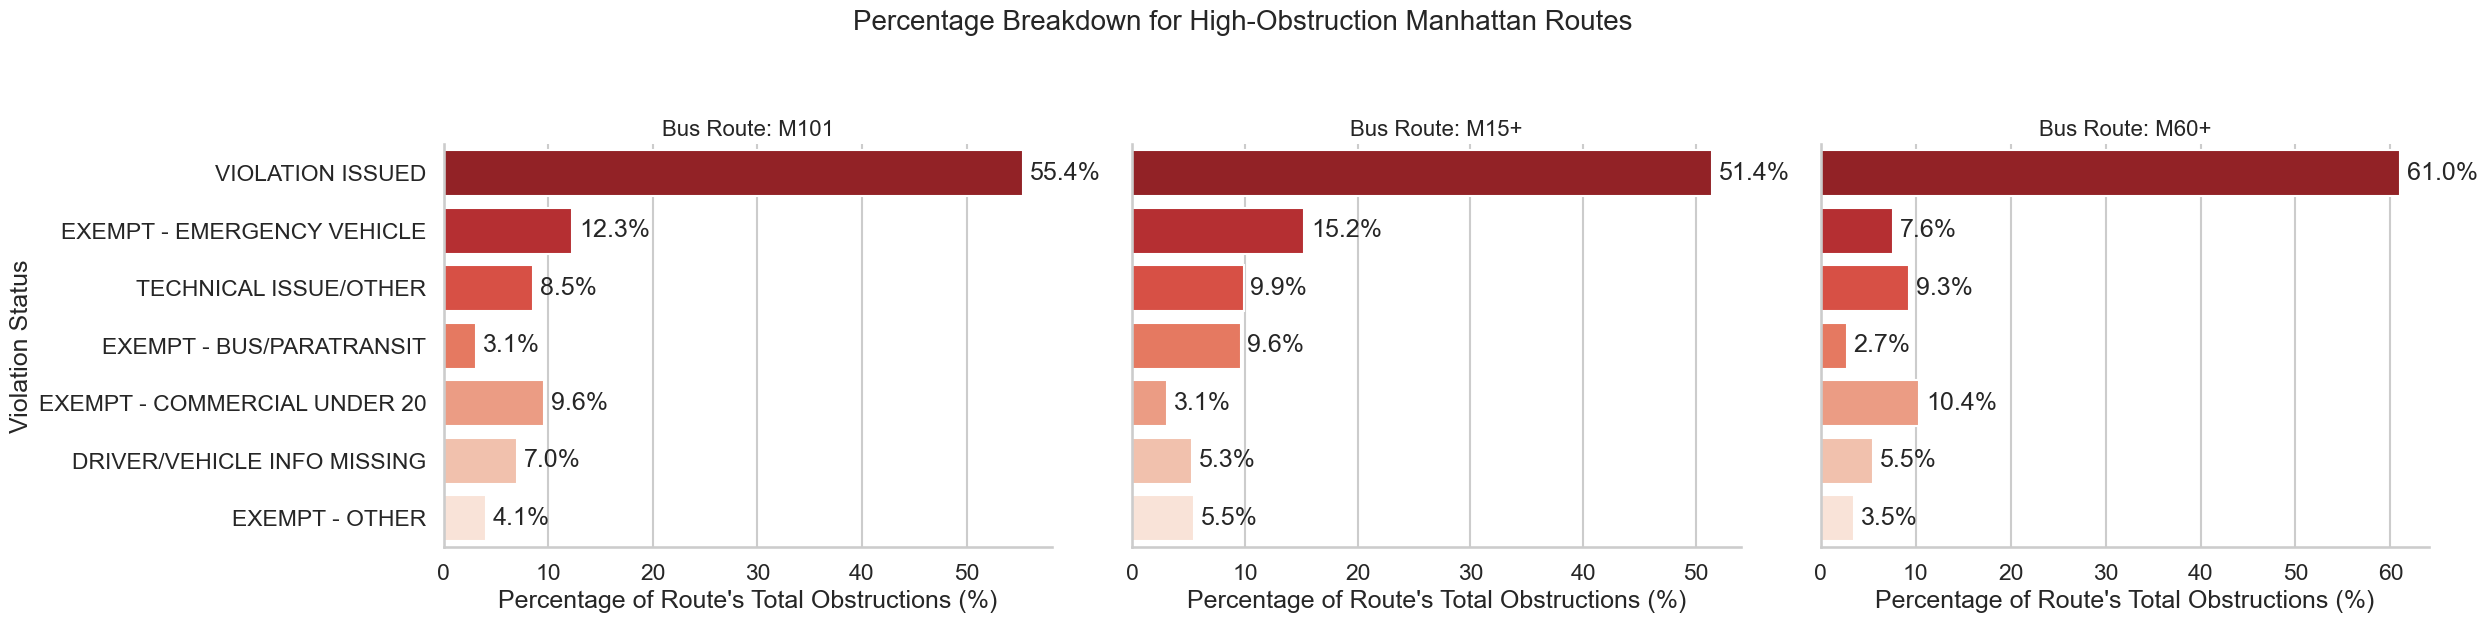

/var/folders/p_/kfck2c0s3054xc_d99qkkpxh0000gn/T/ipykernel_10928/2690365577.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g_manhattan_low_pct = sns.catplot(


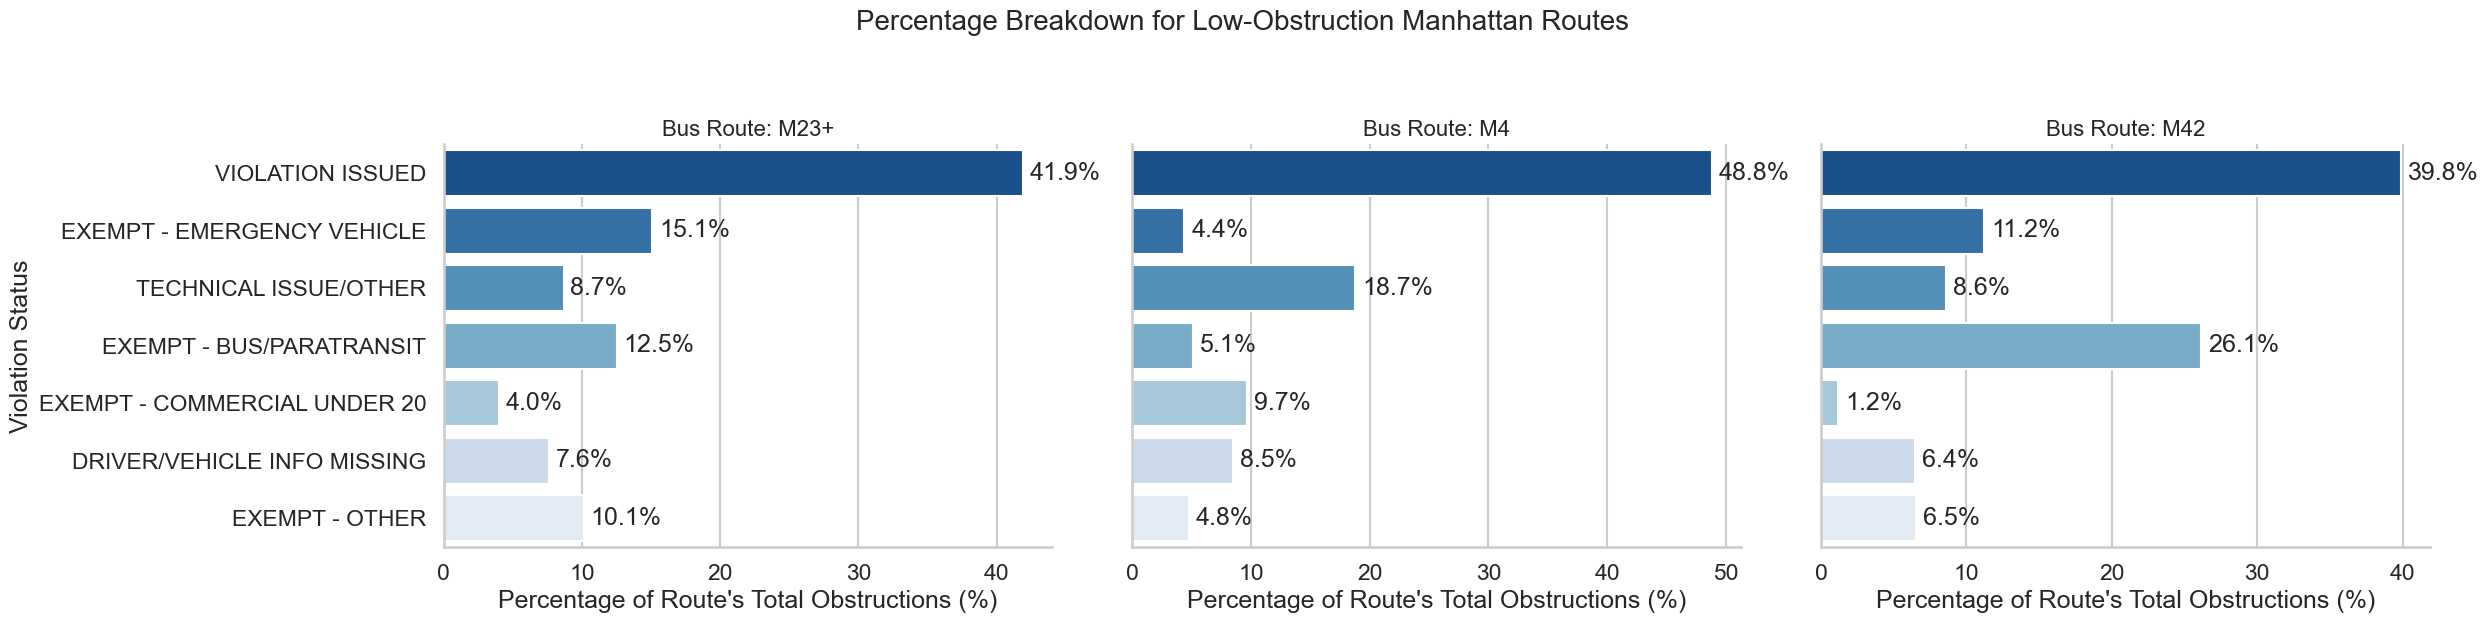


Manhattan percentage-based breakdown complete!


In [17]:

# Load the clean, categorized dataset directly
df_all = pd.read_csv('../data/processed/mta_obstructions_categorized.csv', parse_dates=['First Occurrence'])

# Filter the DataFrame to focus only on Manhattan
df_manhattan = df_all[df_all['Borough'] == 'Manhattan'].copy()
print(f"\nData filtered for Manhattan. Total rows: {len(df_manhattan)}")

# Calculate total obstructions for every route in Manhattan
manhattan_routes = df_manhattan['Bus Route ID'].value_counts()
manhattan_top_3 = manhattan_routes.nlargest(3).index.tolist()
manhattan_bottom_3 = manhattan_routes.nsmallest(3).index.tolist()

print("\n--- Identified Target Manhattan Routes ---")
print(f"High Obstruction Routes: {manhattan_top_3}")
print(f"Low Obstruction Routes:  {manhattan_bottom_3}")

# Combine the lists to create our target dataset of 6 routes
manhattan_target_routes = manhattan_top_3 + manhattan_bottom_3
df_target = df_manhattan[df_manhattan['Bus Route ID'].isin(manhattan_target_routes)].copy()

# Create a new column to label routes as 'High' or 'Low' for easier grouping
def get_obstruction_level(route):
    if route in manhattan_top_3:
        return 'High Obstruction'
    return 'Low Obstruction'
df_target['Obstruction Level'] = df_target['Bus Route ID'].apply(get_obstruction_level)
print("\nTarget DataFrame for Manhattan analysis created.")

# Determine a consistent order for 'Violation Status'
status_order_df = df_target['Violation Status'].value_counts()
consistent_status_order = status_order_df.index.tolist()
print("\n--- Applying Consistent Violation Status Order ---")
print(consistent_status_order)

# Split the Manhattan Target DataFrame into High and Low Groups
df_high_manhattan = df_target[df_target['Obstruction Level'] == 'High Obstruction'].copy()
df_low_manhattan = df_target[df_target['Obstruction Level'] == 'Low Obstruction'].copy()
print(f"\nSplit data into {len(df_high_manhattan['Bus Route ID'].unique())} high-obstruction and {len(df_low_manhattan['Bus Route ID'].unique())} low-obstruction routes.")

# Calculate and Plot for High-Obstruction Manhattan Routes
high_manhattan_percentages = df_high_manhattan.groupby('Bus Route ID')['Violation Status'].value_counts(normalize=True)
high_manhattan_percentages_df = high_manhattan_percentages.mul(100).rename('Percentage').reset_index()

g_manhattan_high_pct = sns.catplot(
    data=high_manhattan_percentages_df, kind='bar', x='Percentage', y='Violation Status',
    col='Bus Route ID', col_wrap=3, sharex=False, height=6, aspect=1.4, palette='Reds_r',
    order=consistent_status_order
)
g_manhattan_high_pct.fig.suptitle('Percentage Breakdown for High-Obstruction Manhattan Routes', y=1.05, fontsize=20)
g_manhattan_high_pct.set_titles("Bus Route: {col_name}", size=16)
g_manhattan_high_pct.set_axis_labels("Percentage of Route's Total Obstructions (%)", "Violation Status")
for ax in g_manhattan_high_pct.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.1f}%', (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.tight_layout()

plt.show()

# Calculate and Plot for Low-Obstruction Manhattan Routes
low_manhattan_percentages = df_low_manhattan.groupby('Bus Route ID')['Violation Status'].value_counts(normalize=True)
low_manhattan_percentages_df = low_manhattan_percentages.mul(100).rename('Percentage').reset_index()

g_manhattan_low_pct = sns.catplot(
    data=low_manhattan_percentages_df, kind='bar', x='Percentage', y='Violation Status',
    col='Bus Route ID', col_wrap=3, sharex=False, height=6, aspect=1.4, palette='Blues_r',
    order=consistent_status_order
)
g_manhattan_low_pct.fig.suptitle('Percentage Breakdown for Low-Obstruction Manhattan Routes', y=1.05, fontsize=20)
g_manhattan_low_pct.set_titles("Bus Route: {col_name}", size=16)
g_manhattan_low_pct.set_axis_labels("Percentage of Route's Total Obstructions (%)", "Violation Status")
for ax in g_manhattan_low_pct.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.1f}%', (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.tight_layout()

plt.show()

print("\nManhattan percentage-based breakdown complete!")

## Section 5: Manhattan Bus Speed Analysis

--- Starting Grouped Bus Speed Analysis ---
Created Group 1 with 1518 rows for routes: ['M15+', 'M60+', 'M101']
Created Group 2 with 1430 rows for routes: ['M42', 'M4', 'M23+']

--- Generating Analysis Plots for Group 1 ---


/var/folders/p_/kfck2c0s3054xc_d99qkkpxh0000gn/T/ipykernel_10928/3217481791.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=overall_avg_speed_g1, x='route_id', y='average_speed', palette='viridis')


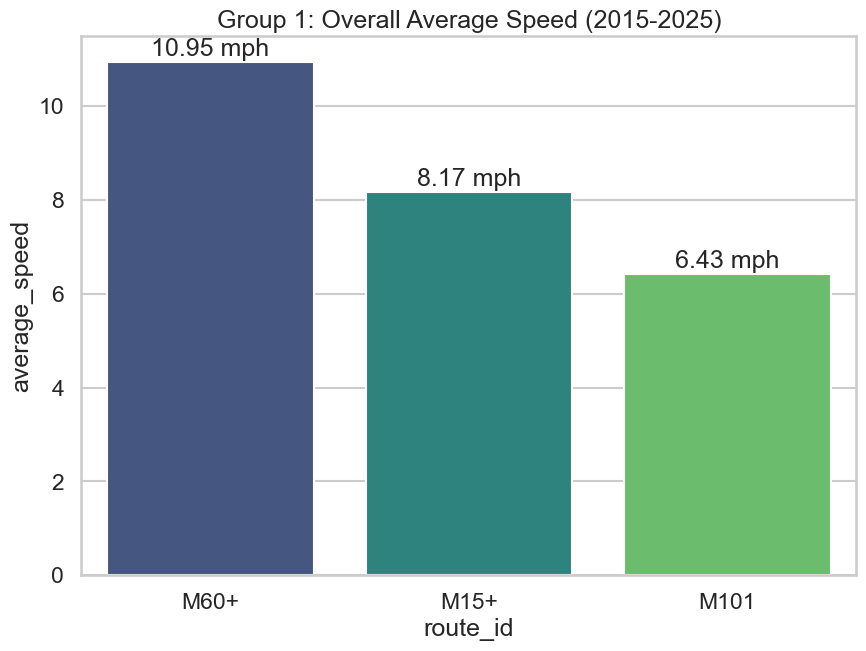

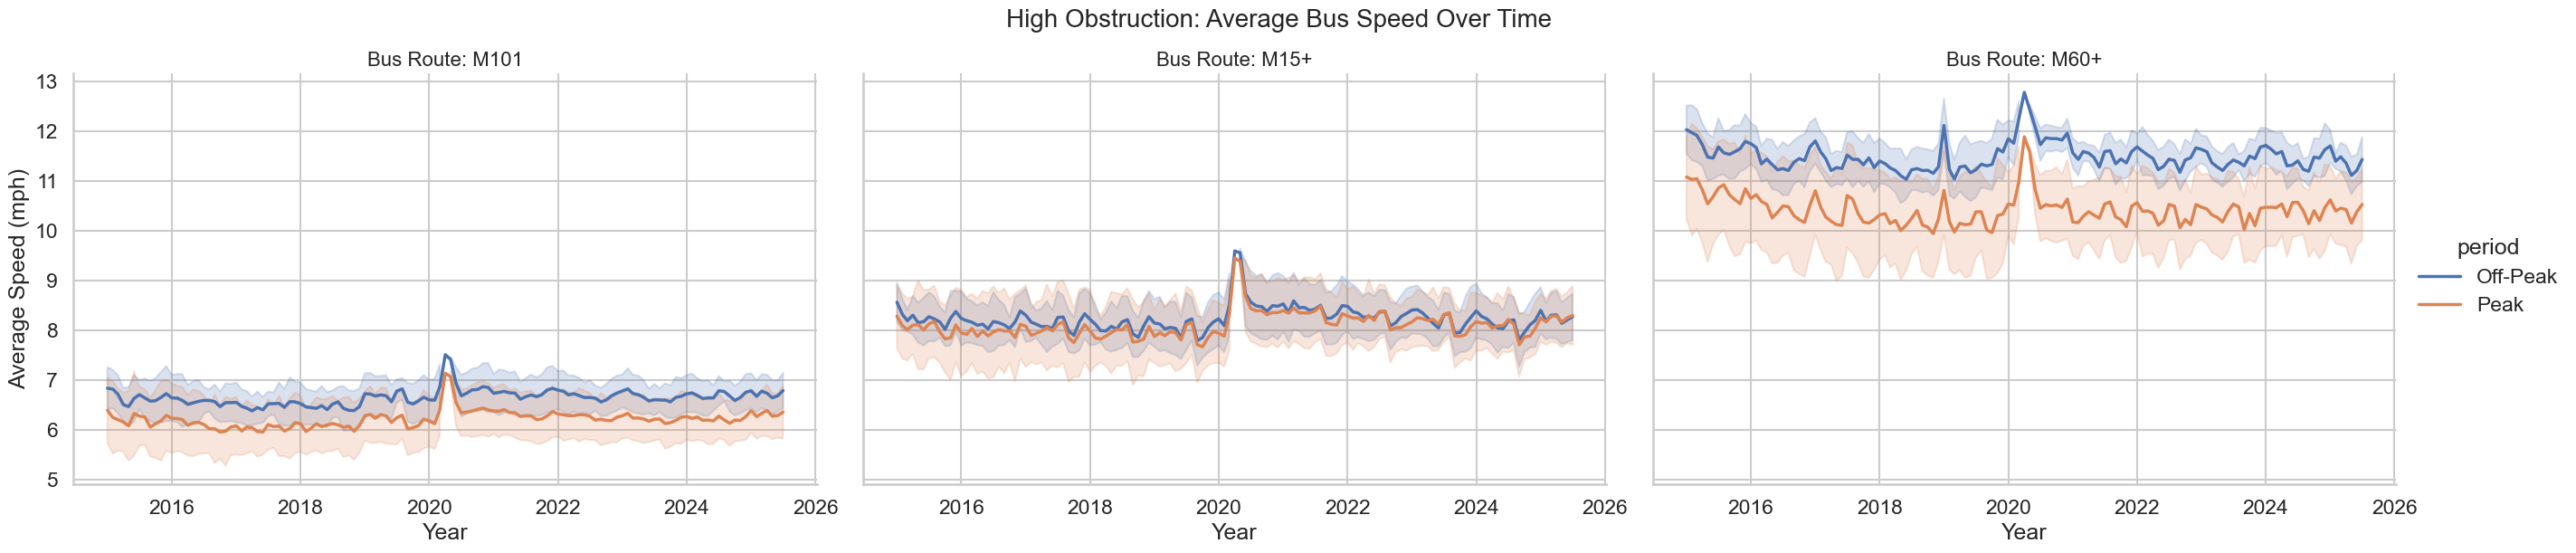


--- Generating Analysis Plots for Group 2 ---


/var/folders/p_/kfck2c0s3054xc_d99qkkpxh0000gn/T/ipykernel_10928/3217481791.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=overall_avg_speed_g2, x='route_id', y='average_speed', palette='plasma')


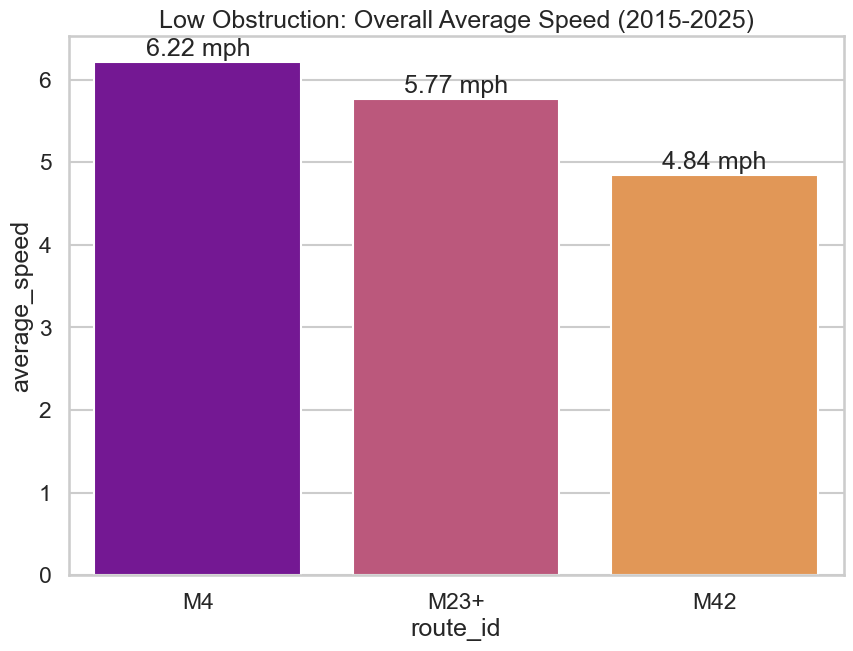

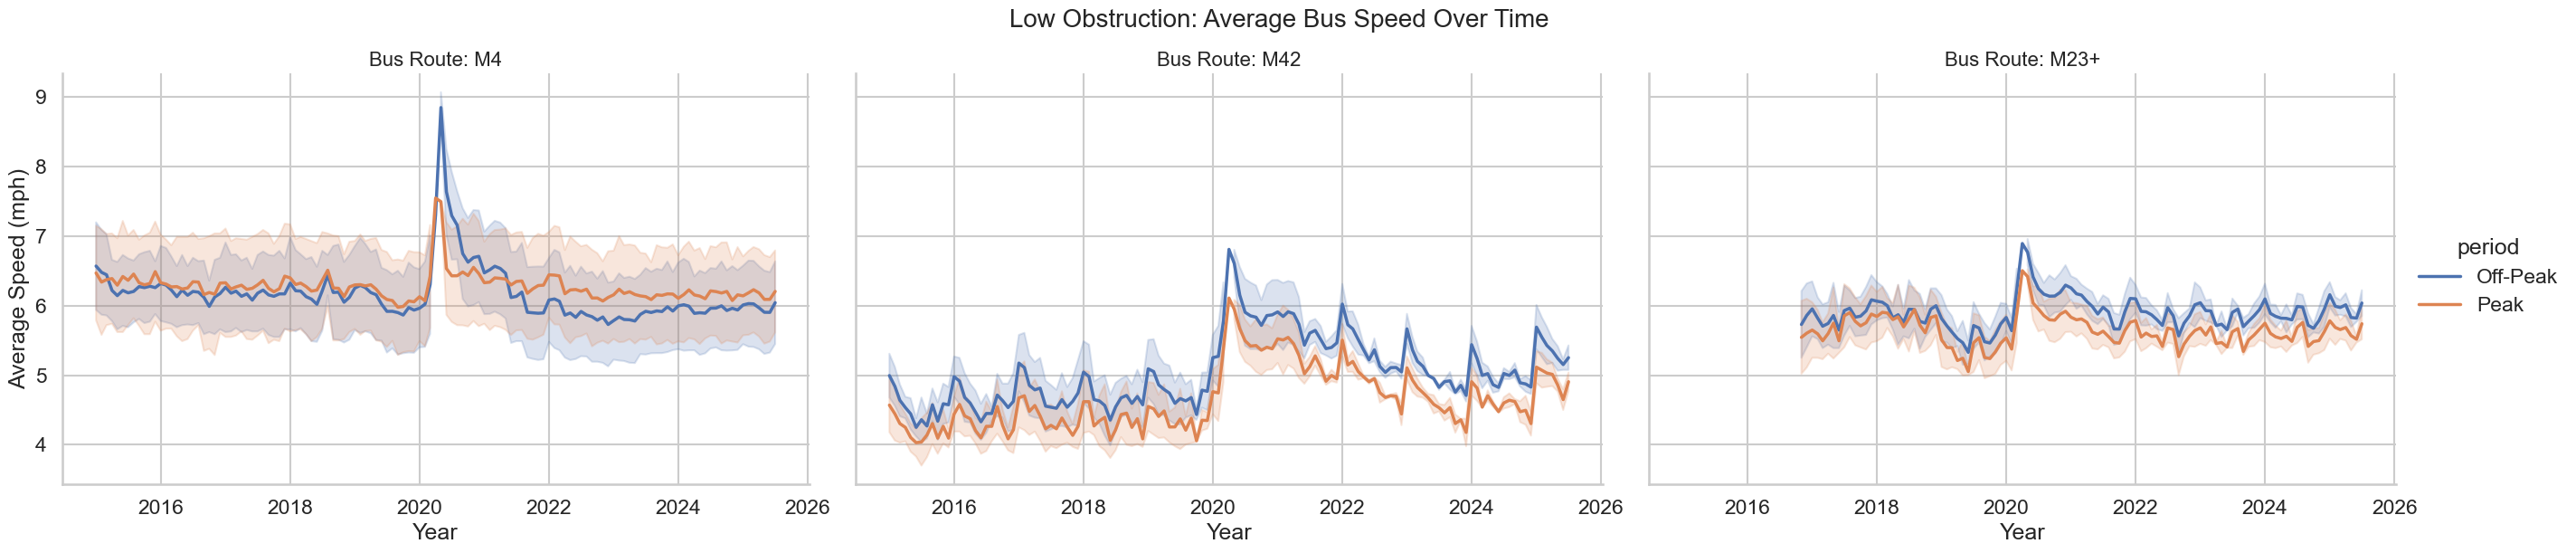


Grouped bus speed analysis complete!


In [18]:
print("--- Starting Grouped Bus Speed Analysis ---")

# Define the routes for each group
group1_routes = ['M15+', 'M60+', 'M101']
group2_routes = ['M42', 'M4', 'M23+']

# Create separate DataFrames for each group
df_group1 = df_speeds[df_speeds['route_id'].isin(group1_routes)].copy()
df_group2 = df_speeds[df_speeds['route_id'].isin(group2_routes)].copy()

print(f"Created Group 1 with {len(df_group1)} rows for routes: {group1_routes}")
print(f"Created Group 2 with {len(df_group2)} rows for routes: {group2_routes}")

# ===================================================================
# 5. Analysis for Group 1 (M15+, M60+, M101)
# ===================================================================
sns.set_theme(style="whitegrid", context="talk")
print("\n--- Generating Analysis Plots for Group 1 ---")

# Plot 1A: Overall Speed Bar Chart (Group 1 High Obstruction)
overall_avg_speed_g1 = df_group1.groupby('route_id')['average_speed'].mean().reset_index().sort_values('average_speed', ascending=False)
plt.figure(figsize=(10, 7))
ax1 = sns.barplot(data=overall_avg_speed_g1, x='route_id', y='average_speed', palette='viridis')
ax1.set_title('Group 1: Overall Average Speed (2015-2025)', fontsize=18)
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f} mph', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.show()

# Plot 1B: Detailed Speed Trends Over Time (Group 1 High Obstruction)
g1 = sns.relplot(data=df_group1, kind='line', x='month', y='average_speed', col='route_id', hue='period', height=6, aspect=1.5, linewidth=2.5)
g1.fig.suptitle('High Obstruction: Average Bus Speed Over Time', y=1.03, fontsize=20)
g1.set_titles("Bus Route: {col_name}", size=16)
g1.set_axis_labels("Year", "Average Speed (mph)")

plt.show()


# ===================================================================
# 6. Analysis for Group 2 (M42, M4, M23+)
# ===================================================================
print("\n--- Generating Analysis Plots for Group 2 ---")

# Plot 2A: Overall Speed Bar Chart (Group 2 Low Obstruction)
overall_avg_speed_g2 = df_group2.groupby('route_id')['average_speed'].mean().reset_index().sort_values('average_speed', ascending=False)
plt.figure(figsize=(10, 7))
ax2 = sns.barplot(data=overall_avg_speed_g2, x='route_id', y='average_speed', palette='plasma')
ax2.set_title('Low Obstruction: Overall Average Speed (2015-2025)', fontsize=18)
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f} mph', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.show()

# Plot 2B: Detailed Speed Trends Over Time (Group 2 Low Obstruction)
g2 = sns.relplot(data=df_group2, kind='line', x='month', y='average_speed', col='route_id', hue='period', height=6, aspect=1.5, linewidth=2.5)
g2.fig.suptitle('Low Obstruction: Average Bus Speed Over Time', y=1.03, fontsize=20)
g2.set_titles("Bus Route: {col_name}", size=16)
g2.set_axis_labels("Year", "Average Speed (mph)")

plt.show()

print("\nGrouped bus speed analysis complete!")